In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import mixture
import scipy as sp
import pydrake
from pydrake.all import (
    MathematicalProgram,
    GurobiSolver,
    SolverOptions,
)

(array([118., 129.,   2.,   7., 350., 149.,   0.,  13., 193.,  39.]),
 array([-1.26641259, -1.00236885, -0.7383251 , -0.47428135, -0.2102376 ,
         0.05380615,  0.3178499 ,  0.58189365,  0.84593739,  1.10998114,
         1.37402489]),
 <BarContainer object of 10 artists>)

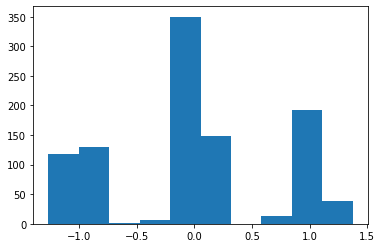

In [2]:
# GMM parsing as a MIP, with binary variables
# as cluster assignments.
np.random.seed(1)
weights = np.array([0.25, 0.25, 0.5])
means = np.array([-1., 1., 0.])
variances = np.array([0.1, 0.1, 0.1])

# Make samples
N = 1000
inds = np.random.choice(len(weights), p=weights, size=N)
samples_full = np.stack(
    [np.random.normal(mean, variance, size=N) for mean, variance in zip(means, variances)]
)
samples = np.array([samples_full[inds[k], k] for k in range(N)])
plt.hist(samples)

In [17]:
prog = MathematicalProgram()

# For a given point, which mode?
print("Associating in point ", samples[0])
association_vars = prog.NewBinaryVariables(len(weights), "associations")
prog.AddLinearConstraint(sum(association_vars) == 1.)

# Cost is GMM association
for k in range(len(weights)):
    prog.AddLinearCost( -association_vars[k] * weights[k])
    prog.AddLinearCost( association_vars[k] * (samples[0] - means[k])**2 / variances[k]**2. )

solver = GurobiSolver()
options = SolverOptions()
options.SetOption(solver.id(), "LogFile", "gurobi.log")
options.SetOption(solver.id(), "PoolSolutions", 3)
options.SetOption(solver.id(), "PoolSearchMode", 2)
        
result = solver.Solve(prog, None, options)

print(result.is_success())
print(result.GetSolution(association_vars))

with open("gurobi.log") as f:
    print(f.read())

for solution_k in range(getattr(result, "num_suboptimal_solution()")()):
    sol = result.GetSuboptimalSolution(association_vars, solution_k)
    print("Sol %d: %s" % (k, sol))

Associating in point  1.0764041420048112
True
[-0.  1. -0.]

Gurobi 9.0.2 (linux64) logging started Wed Sep 22 19:36:22 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x3ad7dc40
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 430.8954161
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Variable types: 0 continuous, 3 integer (3 binary)
Found heuristic solution: objective 115.3645877

Root relaxation: objective 3.337593e-01, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.3337593    0.33376  0.00%     -    0s

Optimal solutio